In [1]:
# load modules and data
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import inspect
from rich.console import Console
import time
from tqdm import tqdm
from whygreedy import *
import pandas as pd
from whygreedy.algo import find_pmgehull
from whygreedy.algo import find_greedy_first_choices, find_greedy_old_first_choices

# set up plotting env
sns.set_theme(style="whitegrid", palette="pastel")
plt.rcParams.update({'font.size': 14})
console = Console(width=120)


In [2]:
# load data precalculated by `calculate.py`
def load():
    # preloaded pairs
    # a `pair` is a tuple of (reactant, product list), each pair corresponds to a reaction
    mp_oxidation_pairs = pkl_load("data/mp_oxidation_pairs.pkl")
    mp_decomposition_pairs = pkl_load("data/mp_decomp_pairs.pkl")

    # precomputed enthalpies and x_i using different methods, each record corresponds to a pair (they have the same list index)
    mp_oxidation_records = pkl_load("data/mp_oxidation_records.pkl")
    mp_decomposition_records = pkl_load("data/mp_decomposition_records.pkl")

    # There are two reactions in `mp_decomposition_pairs`
    # have empty product list (mentioned in II.D in the main text),
    # so we have no iterations in greedy methods and dh values are calculated
    # as the initial value `inf`. we will set them to zero.
    for i, (c, cps) in enumerate(mp_decomposition_pairs):
        if len(cps) == 0:
            print("="*6)
            print(c, c.mpid, cps)
            print("lazy_all dh calculated as", mp_decomposition_records[i]["dh_lazy_all"], "set to 0")
            mp_decomposition_records[i]["dh_lazy_all"] = 0
            print("lazy_f3 dh calculated as", mp_decomposition_records[i]["dh_lazy_f3"], "set to 0")
            mp_decomposition_records[i]["dh_lazy_f3"] = 0
            print("diligent_all dh calculated as", mp_decomposition_records[i]["dh_diligent_all"], "set to 0")
            mp_decomposition_records[i]["dh_diligent_all"] = 0
            print("diligent_f3 dh calculated as", mp_decomposition_records[i]["dh_diligent_f3"], "set to 0")
            mp_decomposition_records[i]["dh_diligent_f3"] = 0

    # lookup tables for EATCH and compound
    mpid_to_compound = dict()
    for c, _ in mp_decomposition_pairs:
        mpid_to_compound[c.mpid] = c

    mpid_to_ehull_MP = dict()
    for d in json_load("data/mp.json.gz"):
        mpid = d["task_id"]
        ehull = d["e_above_hull"]
        mpid_to_ehull_MP[mpid] = ehull

    mpid_to_ehull_PMG = dict()
    for i in range(len(mp_decomposition_pairs)):
        reactant = mp_decomposition_pairs[i][0].mpid
        dh_pmgehull = mp_decomposition_records[i]["dh_pmgehull"]
        mpid_to_ehull_PMG[reactant] = dh_pmgehull

    # look up table for volume and cell
    mpid_to_vol_nsites = dict()
    for d in json_load("data/mp.json.gz"):
        mpid = d["task_id"]
        v = d["volume"]
        nsites = d["nsites"]
        mpid_to_vol_nsites[mpid] = (v, nsites)

    mpid_to_decomposition_pair = {p[0].mpid : p for p in mp_decomposition_pairs}
    mpid_to_oxidation_pair = {p[0].mpid : p for p in mp_oxidation_pairs}

    return mp_decomposition_pairs, mp_decomposition_records, mp_oxidation_pairs, mp_oxidation_records, mpid_to_ehull_PMG, mpid_to_ehull_MP, mpid_to_compound, mpid_to_decomposition_pair, mpid_to_oxidation_pair, mpid_to_vol_nsites

mp_decomposition_pairs, mp_decomposition_records, mp_oxidation_pairs, mp_oxidation_records, mpid_to_ehull_PMG, mpid_to_ehull_MP, mpid_to_compound, mpid_to_decomposition_pair, mpid_to_oxidation_pair, mpid_to_vol_nsites = load()

loaded mp_oxidation_pairs.pkl in: 0.2687 s
loaded mp_decomp_pairs.pkl in: 1.6241 s
loaded mp_oxidation_records.pkl in: 0.9742 s
loaded mp_decomposition_records.pkl in: 12.8336 s
{'Pt': 1.0} mp-126 []
lazy_all dh calculated as inf set to 0
lazy_f3 dh calculated as inf set to 0
diligent_all dh calculated as inf set to 0
diligent_f3 dh calculated as inf set to 0
{'Ne': 1.0} mp-111 []
lazy_all dh calculated as inf set to 0
lazy_f3 dh calculated as inf set to 0
diligent_all dh calculated as inf set to 0
diligent_f3 dh calculated as inf set to 0


In [3]:
def get_num_products(pairs):
    num_products = []
    for pair in pairs:
        r, ps = pair
        num_products.append(len(ps))
    print("# of products: [{}, {}], mean: {:.3f}".format(min(num_products), max(num_products), np.mean(num_products)))
    return num_products

def print_reaction_summary():

    print("# of decomposition reactions:", len(mp_decomposition_records))
    get_num_products(mp_decomposition_pairs)
    print("# of oxidation reactions", len(mp_oxidation_records))
    get_num_products(mp_oxidation_pairs)
    print("")
print_reaction_summary()

# of decomposition reactions: 126320
# of products: [0, 4741], mean: 259.157
# of oxidation reactions 39634
# of products: [1, 820], mean: 48.517



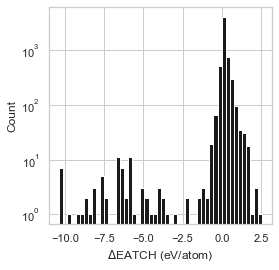

In [4]:
# III.A: Fig.1 Difference in \Delta EATCH
def delta_eatch():
    # cases where MP and PMG ehull values are inconsistent
    ehull_inconsistent = []
    for mpid in mpid_to_ehull_PMG:
        diff = mpid_to_ehull_MP[mpid] - mpid_to_ehull_PMG[mpid]
        if abs(diff) > 1e-5:
            ehull_inconsistent.append(diff)

    fig, ax = plt.subplots(figsize=(4,4))
    ax.hist(ehull_inconsistent, bins=50, facecolor="k", label=r"$\Delta$EATCH")
    # ax.legend()
    ax.set_yscale('log')
    # ax.set_title("{} of {} compounds".format(len(ehull_inconsistent), len(mpid_to_ehull_PMG)))
    ax.set_ylabel("Count")
    ax.set_xlabel(r"$\Delta$EATCH (eV/atom)")

    figname = "fig1_delta_eatch"
    fig.savefig("float/{}.eps".format(figname), bbox_inches="tight")
    fig.savefig("float/{}.tiff".format(figname), bbox_inches="tight", dpi=600, pil_kwargs={"compression": "tiff_lzw"})
    return fig

fig1 = delta_eatch()

In [5]:
# III.A: Potential incomplete product set used in EATCH-MP
def EATCH_MP_vs_PMG(mpid:str):
    target_competing_pair = mpid_to_decomposition_pair[mpid]
    target_c, target_cps = target_competing_pair

    mp_hull = mpid_to_ehull_MP[mpid]
    pymatgen_hull = mpid_to_ehull_PMG[mpid]
    print("decomposition of: {}".format(mpid))
    print("pymatgen simplex gives: {:.6f}".format(pymatgen_hull))
    print("However, value from MP for {} is: {:.6f}".format(mpid, mp_hull))
    print("="*6)

    # what if we exclude a competing phase from the list?
    for i in range(len(target_cps)):
        exclude_index = i
        updated_target_cps = [cp for cp in target_cps]
        updated_target_cps.pop(exclude_index)
        _, pymatgen_hull = find_pmgehull(target_c, updated_target_cps)
        if abs(pymatgen_hull - mp_hull) < 1e-5:
            print("exclude compound {} with formation energy: {:.6f}".format(target_cps[exclude_index].mpid, target_cps[exclude_index].formation_energy_per_atom))
            print("pymatgen simplex gives: {:.6f}".format(pymatgen_hull))
            break
EATCH_MP_vs_PMG("mp-1318211")

decomposition of: mp-1318211
pymatgen simplex gives: 10.402309
However, value from MP for mp-1318211 is: 0.044175
exclude compound mp-778012 with formation energy: -13.568631
pymatgen simplex gives: 0.044175


oxidation diff: min--0.7072 max-0.4891 mean--0.1930
decomposition diff: min--0.6935 max-0.2836 mean--0.0488


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


oxidation diff: min--0.7733 max-0.4891 mean--0.0926
decomposition diff: min--0.3013 max-0.1911 mean--0.0182


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


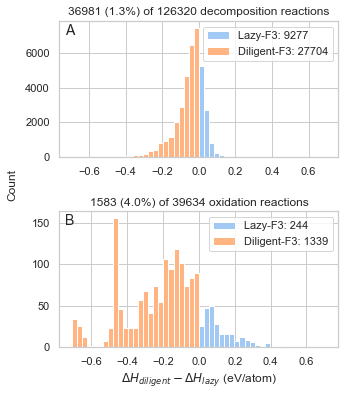

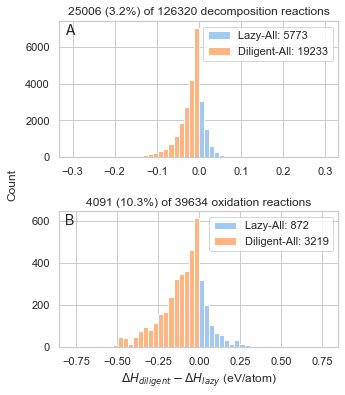

In [6]:
# III.B: Fig.2 and Fig.S1 nonzero diff between Lazy and Diligent for MP reactions
def nonzero_diff(records: list[dict], field1="dh_diligent", field2="dh_old"):
    diff = []
    for i, record in enumerate(records):
        dh_1 = record[field1]
        dh_2 = record[field2]
        if not is_close_to_zero(dh_1 - dh_2):
            diff.append(dh_1 - dh_2)
    return diff

def diff_hist_data(diff, bins=50):
    lim = max([abs(max(diff)), abs(min(diff))])
    heights, bins = np.histogram(diff, bins, range=(-lim, lim))
    bin_width = np.diff(bins)[0]
    bin_pos = bins[:-1] + bin_width / 2
    mask_pos = (bin_pos > 0)
    mask_neg = (bin_pos < 0)
    return bin_pos[mask_pos], heights[mask_pos], bin_pos[mask_neg], heights[mask_neg], bin_width

def fig_diff_hist_data(diff_mpox, diff_mpdc, diligent_label, lazy_label):
    fig, (ax2, ax1) = plt.subplots(figsize=(5, 6), nrows=2, ncols=1)
    x1pos, y1pos, x1neg, y1neg, w1 = diff_hist_data(diff_mpox, 50)
    x2pos, y2pos, x2neg, y2neg, w2 = diff_hist_data(diff_mpdc, 50)
    ax1.bar(x1pos, y1pos,label="{}: {}".format(lazy_label, int(sum(y1pos))), width=w1)
    ax1.bar(x1neg, y1neg,label="{}: {}".format(diligent_label, int(sum(y1neg))), width=w1)
    ax1.legend()
    ax2.bar(x2pos, y2pos,label="{}: {}".format(lazy_label, int(sum(y2pos))), width=w2)
    ax2.bar(x2neg, y2neg,label="{}: {}".format(diligent_label, int(sum(y2neg))), width=w2)
    ax2.legend()
    assert sum(y1pos) + sum(y1neg) == len(diff_mpox)
    assert sum(y2pos) + sum(y2neg) == len(diff_mpdc)
    fig.supylabel("Count", fontsize=12, x=-0.02)
    ax1.set_title("{} ({:.1%}) of {} oxidation reactions".format(len(diff_mpox), len(diff_mpox)/len(mp_oxidation_records), len(mp_oxidation_records)))
    ax2.set_title("{} ({:.1%}) of {} decomposition reactions".format(len(diff_mpdc), len(diff_mpox)/len(mp_decomposition_records), len(mp_decomposition_records)))
    ax1.annotate("B", xy=(0.02, 0.9), xycoords="axes fraction")
    ax2.annotate("A", xy=(0.02, 0.9), xycoords="axes fraction")
    ax1.set_xlabel(r"$\Delta H_{diligent} - \Delta H_{lazy}$ (eV/atom)", fontsize=12)
    fig.subplots_adjust(hspace=0.4)
    return fig

def lazy_vs_diligent(suffix="f3"):
    if suffix == "f3":
        field1, field2= ["dh_diligent_f3", "dh_lazy_f3"]
        label1, label2 = ["Diligent-F3", "Lazy-F3"]
    else:
        field1, field2= ["dh_diligent_all", "dh_lazy_all"]
        label1, label2 = ["Diligent-All", "Lazy-All"]

    diff_mpox_all = nonzero_diff(records=mp_oxidation_records, field1=field1, field2=field2)
    diff_mpdc_all = nonzero_diff(records=mp_decomposition_records, field1=field1, field2=field2)

    print("oxidation diff: min-{:.4f} max-{:.4f} mean-{:.4f}".format(min(diff_mpox_all), max(diff_mpox_all), np.mean(diff_mpox_all)))
    print("decomposition diff: min-{:.4f} max-{:.4f} mean-{:.4f}".format(min(diff_mpdc_all), max(diff_mpdc_all), np.mean(diff_mpdc_all)))

    fig = fig_diff_hist_data(diff_mpox_all, diff_mpdc_all, label1, label2)
    fig.savefig("float/fig2_diligent_vs_lazy_mp_{}.eps".format(suffix), bbox_inches="tight")
    fig.savefig("float/fig2_diligent_vs_lazy_mp_{}.tiff".format(suffix), bbox_inches="tight", dpi=600, pil_kwargs={"compression": "tiff_lzw"})
    return fig

fig2 = lazy_vs_diligent('f3')
figs1 = lazy_vs_diligent('all')

SUFFIX: f3
Lazy: max diff = -1.4801 eV/atom, mean diff = -0.2089
mean diff including zeros = -0.1186
qualitative diff = 22504 same as quantitative diff?: True
Diligent: max diff = -1.4801 eV/atom, mean diff = -0.2006
mean diff including zeros = -0.1109
qualitative diff = 21906 same as quantitative diff?: True
Do lazy and diligent always both get things wrong? False
# of cases where both laze and diligent are wrong: 21823
SUFFIX: all
Lazy: max diff = -0.7733 eV/atom, mean diff = -0.0929
mean diff including zeros = -0.0250
qualitative diff = 10675 same as quantitative diff?: True
Diligent: max diff = -0.5424 eV/atom, mean diff = -0.0647
mean diff including zeros = -0.0155
qualitative diff = 9471 same as quantitative diff?: True
Do lazy and diligent always both get things wrong? False
# of cases where both laze and diligent are wrong: 8935


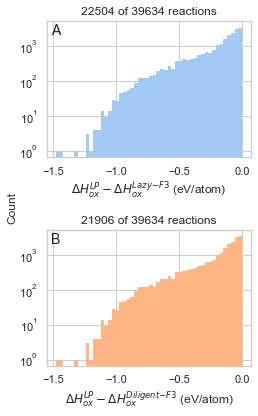

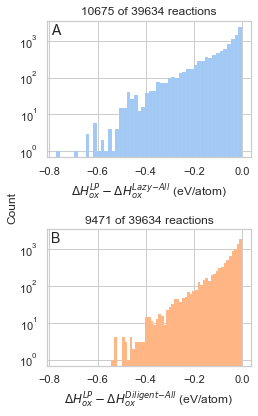

In [7]:
# III.C: Fig. 3 nonzero diff between LP and greedy for oxidation reactions
def set_small_to_zeros(a: list[float], eps=1e-5):
    """supress small values in a list of float"""
    a = np.array(a)
    a[np.abs(a) < eps] = 0
    return a

def is_qualitative_diff(sol1, sol2):
    """test if nonzero values have different indices from two solutions"""
    sol_lazy = set_small_to_zeros(sol1).astype(bool)
    sol_exact = set_small_to_zeros(sol2).astype(bool)
    for i in range(len(sol_lazy)):
        if sol_lazy[i] != sol_exact[i]:
            return True
    return False

def plot_greedy_vs_exact_hist(records, eps=1e-5, f3=False, reaction_type="ox"):
    nonzero_diff_lazy = []
    nonzero_diff_diligent = []
    lazy_wrong = []
    lazy_wrong_quali = []
    diligent_wrong = []
    diligent_wrong_quali = []
    for i, record in enumerate(records):
        if f3:
            dh_lazy = record["dh_lazy_f3"]
            dh_diligent = record["dh_diligent_f3"]
            dh_lp = record["dh_lp"]
            diff_lazy = dh_lp - dh_lazy
            diff_diligent = dh_lp - dh_diligent
            sol_lazy = record["sol_lazy_f3"]
            sol_diligent = record["sol_diligent_f3"]
            sol_lp = record["sol_lp"]
        else:
            dh_lazy = record["dh_lazy_all"]
            dh_diligent = record["dh_diligent_all"]
            dh_lp = record["dh_lp"]
            diff_lazy = dh_lp - dh_lazy
            diff_diligent = dh_lp - dh_diligent
            sol_lazy = record["sol_lazy_all"]
            sol_diligent = record["sol_diligent_all"]
            sol_lp = record["sol_lp"]

        # exact should never be worse
        assert diff_diligent < 1e-7
        assert diff_lazy < 1e-7

        if is_qualitative_diff(sol_lp, sol_diligent):
            diligent_wrong_quali.append(i)

        if is_qualitative_diff(sol_lp, sol_lazy):
            lazy_wrong_quali.append(i)

        if abs(diff_diligent) > eps:
            diligent_wrong.append(i)
            nonzero_diff_diligent.append(diff_diligent)

        if abs(diff_lazy) > eps:
            lazy_wrong.append(i)
            nonzero_diff_lazy.append(diff_lazy)

    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(4, 6))
    ylim = None
    xlim = None
    palette = iter(sns.color_palette(n_colors=6))
    if f3:
        suffix = "F3"
    else:
        suffix = "All"
    for name, data, ax, quali, quanti in zip(
        ["Lazy", "Diligent",],
        [nonzero_diff_lazy, nonzero_diff_diligent],
        [ax1, ax2],
        [lazy_wrong_quali, diligent_wrong_quali],
        [lazy_wrong, diligent_wrong]
    ):
        ax.hist(data, linewidth=0.05, bins=50, facecolor=next(palette))
        ax.set_yscale("log")
        ax.set_title("{} of {} reactions".format(len(data), len(records)))
        ax.set_xlabel(r"$\Delta H^{{LP}}_{{{}}} - \Delta H^{{{}}}_{{{}}}$ (eV/atom)".format(reaction_type, name + "\u2212" + suffix, reaction_type))
        if xlim is None:
            xlim = ax.get_xlim()
        else:
            this_xlim = ax.get_xlim()
            xlim = [min([this_xlim[0], xlim[0]]), max([this_xlim[1], xlim[1]])]
        if ylim is None:
            ylim = ax.get_ylim()
        else:
            this_ylim = ax.get_ylim()
            ylim = [min([this_ylim[0], ylim[0]]), max([this_ylim[1], ylim[1]])]
        print("{}: max diff = {:.4f} eV/atom, mean diff = {:.4f}".format(name, min(data), np.mean(data)))
        print("mean diff including zeros = {:.4f}".format(sum(data)/len(records)))
        print("qualitative diff = {}".format(len(quali)), "same as quantitative diff?: {}".format(set(quali) == set(quanti)))
    for ax in [ax1, ax2]:
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
    ax1.annotate("A", xy=(0.02, 0.9), xycoords="axes fraction")
    ax2.annotate("B", xy=(0.02, 0.9), xycoords="axes fraction")
    fig.supylabel("Count", fontsize=12, x=0.1)
    fig.tight_layout()
    print("Do lazy and diligent always both get things wrong?", set(lazy_wrong) == set(diligent_wrong))
    both_wrong = set(lazy_wrong).intersection(set(diligent_wrong))
    print("# of cases where both laze and diligent are wrong:", len(both_wrong))
    return fig, lazy_wrong, diligent_wrong


def greedy_vs_lp_oxidation(suffix='f3'):
    print("="*6)
    print("SUFFIX: {}".format(suffix))
    if suffix == 'f3':
        fig, lazy_wrong, diligent_wrong = plot_greedy_vs_exact_hist(mp_oxidation_records, f3=True, reaction_type="ox")
    else:
        fig, lazy_wrong, diligent_wrong = plot_greedy_vs_exact_hist(mp_oxidation_records, f3=False, reaction_type="ox")
    figname = "fig3_greedy_vs_lp_mpox_{}".format(suffix)
    fig.savefig("float/{}.eps".format(figname), bbox_inches="tight")
    fig.savefig("float/{}.tiff".format(figname), bbox_inches="tight", dpi=600, pil_kwargs={"compression": "tiff_lzw"})
    return fig

fig3 = greedy_vs_lp_oxidation('f3')
figs3 = greedy_vs_lp_oxidation('all')

Lazy-F3 -4.802 2.474
Diligent-F3 -4.809 2.469
Lazy-All -4.895 2.46
Diligent-All -4.905 2.46
LP -4.92 2.459


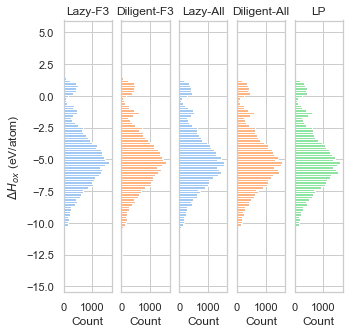

In [8]:
# III.C Fig. S4 qualitatively similar distributions of delta H for oxidation reactions
# i.e. reproduce Fig. 6 (a) from Twyman et al.
def plot_greedy_vs_exact_dist(records):
    lazy_oxidation_dhs_f3 = []
    diligent_oxidation_dhs_f3 = []
    lazy_oxidation_dhs = []
    diligent_oxidation_dhs = []
    exact_oxidation_dhs = []
    for r in records:
        lazy_oxidation_dhs_f3.append(r["dh_lazy_f3"])
        diligent_oxidation_dhs_f3.append(r["dh_diligent_f3"])
        lazy_oxidation_dhs.append(r["dh_lazy_all"])
        diligent_oxidation_dhs.append(r["dh_diligent_all"])
        exact_oxidation_dhs.append(r["dh_lp"])

    fig, axes = plt.subplots(ncols=5, nrows=1, figsize=(5, 5), sharey=True, sharex=True)

    ylabel_already_set = False
    palette = list(iter(sns.color_palette(n_colors=6)))
    colors = [palette[0], palette[1], palette[0], palette[1], palette[2]]
    for ax, data, title, color in zip(
            axes,
            [lazy_oxidation_dhs_f3, diligent_oxidation_dhs_f3, lazy_oxidation_dhs, diligent_oxidation_dhs, exact_oxidation_dhs],
            ["Lazy-F3", "Diligent-F3", "Lazy-All", "Diligent-All", "LP"],
            colors
    ):
        # ax.hist(data, bins=100, orientation="horizontal", facecolor=next(palette), label=title)
        ax.hist(data, bins=100, orientation="horizontal", facecolor=color, label=title)
        ax.set_title(title)
        print(title, round(np.mean(data), 3), round(np.std(data), 3))
        # ax.legend(loc="lower center", fontsize=10)
        if not ylabel_already_set:
            ax.set_ylabel(r"$\Delta H_{ox}$ (eV/atom)")
            ylabel_already_set = True
        ax.set_xlabel("Count")
        # ax.set_xscale("log")
    figname = "mpox_dh_distributions"
    fig.savefig("float/figs4_{}.eps".format(figname), bbox_inches="tight")
    fig.savefig("float/figs4_{}.tiff".format(figname), bbox_inches="tight", dpi=600, pil_kwargs={"compression": "tiff_lzw"})
    return fig


figs4 = plot_greedy_vs_exact_dist(records=mp_oxidation_records)

In [9]:
# III.C examples of different Lazy-F3 and LP solutions
def formula_dict_to_string(d:dict):
    return " ".join(["{}{:.3f}".format(k, v) for k, v in d.items()])

def format_solution(oxides: list[Compound], solution:np.ndarray) -> str:
    s = ""
    final = 0
    for i, oxi in zip(solution, oxides):
        if is_close_to_zero(i):
            continue
        s += "\t{:.4f} -- {} -- {:.2f} -- {}\n".format(i, formula_dict_to_string(oxi.normalized_formula), oxi.formation_energy_per_atom, oxi.mpid)
        final += oxi.formation_energy_per_atom * i
    s += "\tformation enthalpy sum of products: {:.6f}".format(final)
    return s

def print_high_dh_diff(records, pairs, greedy_field_suffix="lazy_f3", k=5, reverse=False):
    assert len(records) == len(pairs)
    dh_diff_records = []
    for i in range(len(records)):
        reactant, products = pairs[i]
        ddh = records[i]["dh_lp"] - records[i]["dh_{}".format(greedy_field_suffix)]
        if abs(ddh) < 1e-5:
            continue
        r = {
            "reactant": reactant,
            "products": products,
            "sol_greedy": records[i]["sol_{}".format(greedy_field_suffix)],
            "sol_lp": records[i]["sol_lp"],
            "ddh": ddh,
        }
        dh_diff_records.append(r)

    high_h_diff= sorted(dh_diff_records, key=lambda x:x["ddh"], reverse=reverse)
    for r in high_h_diff[:k]:
        original = r["reactant"]
        oxides = r["products"]
        sol_greedy = r["sol_greedy"]
        sol_lp = r["sol_lp"]
        print("="*6)
        print("Reactant: " + formula_dict_to_string(original.normalized_formula) + "\t" + original.mpid)
        print("EXACT solution:")
        print(format_solution(oxides, sol_lp))
        print("{} GREEDY solution:".format(greedy_field_suffix))
        print(format_solution(oxides, sol_greedy))

print("***"*6 + "High to low")
print_high_dh_diff(mp_oxidation_records, mp_oxidation_pairs, "lazy_f3", 3, reverse=False)
print("***"*6 + "Low to high")
print_high_dh_diff(mp_oxidation_records, mp_oxidation_pairs,"lazy_f3", 3, reverse=True)

******************High to low
Reactant: Sr0.500 Se0.250 S0.250	mp-1218707
EXACT solution:
	1.5000 -- Sr0.167 S0.167 O0.667 -- -2.80 -- mp-5285
	1.5000 -- Sr0.167 Se0.167 O0.667 -- -2.16 -- mp-4092
	formation enthalpy sum of products: -7.448088
lazy_f3 GREEDY solution:
	1.0000 -- S0.250 O0.750 -- -1.75 -- mp-2414
	0.8750 -- Se0.286 O0.714 -- -1.03 -- mp-27358
	1.5000 -- Sr0.333 O0.667 -- -2.21 -- mp-2697
	formation enthalpy sum of products: -5.967983
Reactant: Sr0.500 Se0.375 S0.125	mp-1218389
EXACT solution:
	0.7500 -- Sr0.167 S0.167 O0.667 -- -2.80 -- mp-5285
	2.2500 -- Sr0.167 Se0.167 O0.667 -- -2.16 -- mp-4092
	formation enthalpy sum of products: -6.966090
lazy_f3 GREEDY solution:
	0.5000 -- S0.250 O0.750 -- -1.75 -- mp-2414
	1.3125 -- Se0.286 O0.714 -- -1.03 -- mp-27358
	1.5000 -- Sr0.333 O0.667 -- -2.21 -- mp-2697
	formation enthalpy sum of products: -5.542496
Reactant: Gd0.333 S0.333 F0.333	mp-3799
EXACT solution:
	2.3333 -- Gd0.143 S0.143 O0.571 F0.143 -- -3.07 -- mp-16801
	form

In [10]:
# III.C solutions for oxidation reactions by different method
def json_dump_solutions(pairs, records, jsonfile):
    def compound_to_dict(c):
        return {'mpid': c.mpid, 'formation_energy_per_atom': c.formation_energy_per_atom}
    assert len(pairs) == len(records)
    solutions = []
    for i in tqdm(range(len(pairs))):
        reactant, products = pairs[i]
        solution_dict = {
            "reactant": compound_to_dict(reactant),
            "products": [compound_to_dict(p) for p in products],
        }
        solution_dict.update(records[i])
        solutions.append(solution_dict)
    json_dump(solutions, jsonfile, compress=False)

json_dump_solutions(mp_oxidation_pairs, mp_oxidation_records, "output/oxidation_reaction_solution.json")

100%|██████████| 39634/39634 [00:04<00:00, 9343.22it/s] 


100%|██████████| 19/19 [00:05<00:00,  3.49it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


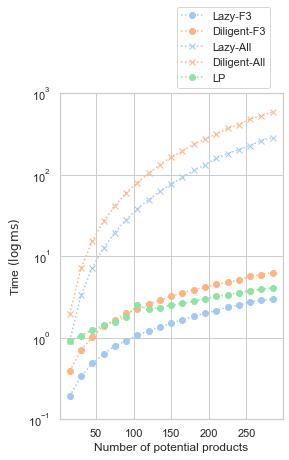

In [11]:
# III.C: timing

def timing(find_function, reactant, products, **kwargs):
    ts1 = time.perf_counter()
    find_function(reactant, products, **kwargs)
    ts2 = time.perf_counter()
    return 1000 * (ts2 - ts1)

def rm_outlier(l):
    l = np.array(l)
    l = l[(l>np.quantile(l,0.1)) & (l<np.quantile(l,0.9))].tolist()
    return l

def timing_scale(find_function, num_oxides_per_chemsys = tuple(range(1, 10)), repeat=500, **kwargs):
    xs = []
    means = []
    stds = []
    for n in tqdm(num_oxides_per_chemsys):
        reactant, products = gen_random_data(["A", "B", "C", "D"], n, 42)
        xs.append(len(products))
        ys = []
        for _ in range(repeat):
            ys.append(timing(find_function, reactant, products, **kwargs))
        ys = rm_outlier(ys)
        means.append(np.mean(ys))
        stds.append(np.std(ys))
    return xs, means, stds


def timing_plot(
        find_funcs, func_kwargss, names, colors, markers,
        num_oxides_per_chemsys = tuple(range(1, 20)), repeat=500
):
    fig, ax = plt.subplots(figsize=(4, 6))
    for find_func, func_kwargs, name, c, m in zip(find_funcs, func_kwargss, names, colors, markers):
        xs, means, stds = timing_scale(find_func, num_oxides_per_chemsys, repeat, **func_kwargs)
        # ax.errorbar(xs, means, ls=":", marker=m, yerr=stds, label=name, color=c)
        ax.plot(xs, means, ls=":", marker=m, label=name, color=c)
    ax.set_xlabel("Number of potential products")
    ax.set_ylabel("Time $(\log \mathrm{ms})$")
    ax.set_ylim([0.1, 1000])
    ax.set_yscale("log")
    ax.legend(ncol=1, bbox_to_anchor=(0.5, 1))
    return fig

def timing_greedy_vs_lp():
    # greedy f3 vs LP
    find_funcs = [
        find_greedy_old_first_choices,
        find_greedy_first_choices,
        find_greedy_old_first_choices,
        find_greedy_first_choices,
        find_lp,
    ]
    func_kwargss = [
        {"for_oxide": True, "firstk": 3},
        {"for_oxide": True, "firstk": 3, "diligent_greedy": True},
        {"for_oxide": True, "firstk": None},
        {"for_oxide": True, "firstk": None, "diligent_greedy": True},
        {}
    ]
    names = ["Lazy-F3", "Diligent-F3", "Lazy-All", "Diligent-All", "LP"]
    color_iter = iter(sns.color_palette(n_colors=3))
    lazy_color, diligent_color, lp_color = list(color_iter)
    colors = [lazy_color, diligent_color, lazy_color, diligent_color, lp_color]
    markers = ["o", "o", "x", "x", "o"]

    fig_timing = timing_plot(find_funcs, func_kwargss, names, colors, markers, repeat=100)
    fig_timing.savefig("float/fig4_timing.eps", bbox_inches="tight",)
    fig_timing.savefig("float/fig4_timing.tiff", bbox_inches="tight", dpi=600, pil_kwargs={"compression": "tiff_lzw"})
    return fig_timing

fig4 = timing_greedy_vs_lp()

In [12]:
# III.C compare greedy vs LP code
def count_dry_source_code(s:str):
    dry_lines = 0
    for line in s.split("\n"):
        if line.strip().startswith("#"):
            continue
        elif len(line.strip()) == 0:
            continue
        else:
            dry_lines += 1
    return dry_lines

def count_implementation(func_list):
    return sum(count_dry_source_code(inspect.getsource(f)) for f in func_list)

def compare_implementation_counts():
    greedy = count_implementation([find_greedy, find_greedy_first_choices, calculate_ranking_parameter])
    lp = count_implementation([find_lp])
    print("Dry lines greedy vs lp: {} vs {}".format(greedy, lp))

compare_implementation_counts()

Dry lines greedy vs lp: 76 vs 37


fig5_data: dh_lazy_f3 mean: -0.031251 mae: 0.039460
range: [-2.6375, 10.3310]
fig5_data: dh_diligent_f3 mean: -0.029101 mae: 0.037327
range: [-2.6375, 10.3455]
fig5_data: dh_lp mean: -0.001784 mae: 0.010559
range: [-2.5670, 10.3581]
fig5_data: dh_pmgehull mean: -0.001784 mae: 0.010559
range: [-2.5670, 10.3581]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


fig5_data: dh_lazy_f3 mean: -0.029466 mae: 0.029466
range: [-1.1434, 0.0000]
fig5_data: dh_diligent_f3 mean: -0.027316 mae: 0.027316
range: [-1.1458, 0.0000]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


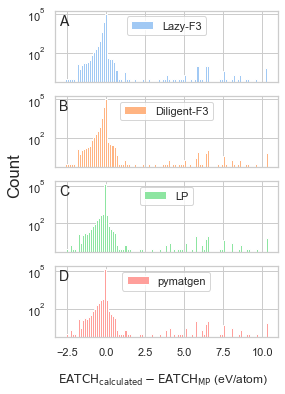

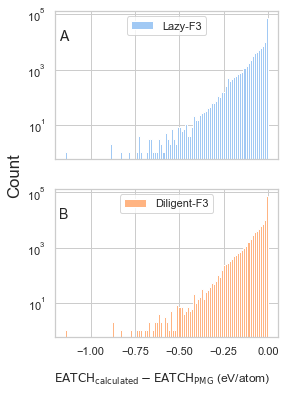

In [13]:
# III.D Delta EATCH by different methods (i.e. SI section III)

def mae(x):
    d = np.array(x)
    return np.mean(np.abs(d))

def generate_fig5_data(records, pairs, dh_field, ehull_mp=True):
    """
    [from page 2549 of the original article]
    > changing all positive reaction enthalpies to a value
    > of 0 meV/atom to match the “stable” EATCH values and
    > making positive all remaining negative reaction enthalpies.
    """
    fig5_data = []
    for p, record in zip(pairs, records):
        reactant, products = p
        dh = record[dh_field]
        if not "pmg" in dh_field:
            if dh > 0:
                dh = 0
            else:
                dh = - dh
        if ehull_mp:
            ehull = mpid_to_ehull_MP[reactant.mpid]
        else:
            ehull = mpid_to_ehull_PMG[reactant.mpid]

        fig5_delta = dh - ehull
        # if supress_small_values and abs(fig5_delta) < supress_small_values:
        #     fig5_delta = 0.0
        fig5_data.append(fig5_delta)
    fig5_data = np.array(fig5_data)
    print(
        "fig5_data:", dh_field,
        "mean: {:.6f}".format(np.mean(fig5_data)),
        "mae: {:.6f}".format(mae(fig5_data)),
    )
    print("range: [{:.4f}, {:.4f}]".format(min(fig5_data), max(fig5_data)))
    return fig5_data

def plot_fig5(f3=False, include_exact=False, ehull_mp=True):
    if f3:
        fig5_data_old = generate_fig5_data(mp_decomposition_records, mp_decomposition_pairs, dh_field="dh_lazy_f3", ehull_mp=ehull_mp)
        fig5_data_diligent = generate_fig5_data(mp_decomposition_records, mp_decomposition_pairs, dh_field="dh_diligent_f3", ehull_mp=ehull_mp)
        columns = ["Lazy-F3", "Diligent-F3", "LP", "pymatgen"]
    else:
        fig5_data_old = generate_fig5_data(mp_decomposition_records, mp_decomposition_pairs, dh_field="dh_lazy_all", ehull_mp=ehull_mp)
        fig5_data_diligent = generate_fig5_data(mp_decomposition_records, mp_decomposition_pairs, dh_field="dh_diligent_all", ehull_mp=ehull_mp)
        columns = ["Lazy-All", "Diligent-All", "LP", "pymatgen"]
    if include_exact:
        fig5_data_lp = generate_fig5_data(mp_decomposition_records, mp_decomposition_pairs, dh_field="dh_lp", ehull_mp=ehull_mp)
        fig5_data_pmg = generate_fig5_data(mp_decomposition_records, mp_decomposition_pairs, dh_field="dh_pmgehull", ehull_mp=ehull_mp)

        fig5_df = pd.DataFrame(np.array([fig5_data_old, fig5_data_diligent, fig5_data_lp, fig5_data_pmg]).T, columns=columns)
    else:
        fig5_df = pd.DataFrame(np.array([fig5_data_old, fig5_data_diligent]).T, columns=columns[:2])

    fig, axes = plt.subplots(len(fig5_df.columns), 1, figsize=(4, 6), sharex=True)
    if ehull_mp:
        fig.supxlabel(r"$\mathrm{EATCH}_{\mathrm{calculated}} -\mathrm{EATCH}_{\mathrm{MP}}$ (eV/atom)", fontsize=12)
    else:
        fig.supxlabel(r"$\mathrm{EATCH}_{\mathrm{calculated}} -\mathrm{EATCH}_{\mathrm{PMG}}$ (eV/atom)", fontsize=12)
    #
    colors = sns.color_palette("pastel")
    figlabels = ["A", "B", "C", "D"]
    for i, col in enumerate(fig5_df.columns):
        data = fig5_df[col]
        axes[i].annotate(figlabels[i], xy=(0.02, 0.8), xycoords="axes fraction")
        axes[i].hist(data, bins=100, facecolor=colors[i], label=col)
        axes[i].legend(loc="upper center")
        axes[i].set_yscale('log')
    fig.supylabel("Count", x=-0.04)
    figname = "figs5_delta_eatch_"
    if ehull_mp:
        figname += "mpehull_"
    else:
        figname += "pmgehull_"
    if f3:
        figname += "f3"
    else:
        figname += "all"
    fig.savefig("float/{}.eps".format(figname), bbox_inches="tight")
    fig.savefig("float/{}.tiff".format(figname), bbox_inches="tight", dpi=600, pil_kwargs={"compression": "tiff_lzw"})
    return fig

figs5 = plot_fig5(f3=True, include_exact=True, ehull_mp=True)
figs6 = plot_fig5(f3=True, include_exact=False, ehull_mp=False)

In [14]:
# III.D Fig.5 of Twyman et al.
# The caption of Fig. 5 says "... the 126 320 materials in the MP database."
# We extracted the data from the bar chart, and we find the sum of all bars is around 98.2K.
# Data extraction was performed using [WebPlotDigitizer](https://apps.automeris.io/wpd/)
# and extracted data can be found in [data/fig5.json](./data/part2/fig5.json)
# (the image used for extraction is [data/fig5.jpeg](./data/part2/fig5.jpeg)).
# The mean value of the extracted data ranges is estimated to be 0.025543 ~ 0.024457 eV/atom,
# which is quite different from 0.0395 eV/atom from the original paper.
# Thus, it is possible that Fig. 5 from the original paper is showing truncated data.
def inspect_fig5():
    # sum of bars in the original fig. 5
    original_fig5_data = json_load("data/fig5.json")["datasetColl"][0]["data"]
    original_fig5_data = [r["value"][0] for r in original_fig5_data]
    original_fig5_data_total = sum(original_fig5_data) * 1e4
    print("sum of bars:", original_fig5_data_total)

    # estimate range of MAE
    barwidth = 0.05 / (len(original_fig5_data) - 1)  # discard two half-bars outside the range
    # from right to left, first bar
    right_edge = 0.5 * barwidth
    left_edge = 0.5 * -barwidth
    data_max = []
    data_min = []
    for i, v in enumerate(original_fig5_data):
        if i != 0:
            right_edge = left_edge
            left_edge = right_edge - barwidth
        data_max.append(right_edge)
        data_min.append(left_edge)
    print("range of the mean value: {:.6f} -- {:.6f}".format(np.mean(data_min), np.mean(data_max)))

inspect_fig5()

sum of bars: 98178.55790822612
range of the mean value: -0.025543 -- -0.024457


In [15]:
# III.E PBR screening
def calculate_pbr(reactant_pbr: Compound, products_pbr: list[Compound], sol:list[float],):
    v_reactant, nsites_reactant = mpid_to_vol_nsites[reactant_pbr.mpid]
    pbrs = []
    for x_i, product in zip(sol, products_pbr):
        if x_i <= 1e-5:
            pbr = None
        else:
            v_product, nsites_product = mpid_to_vol_nsites[product.mpid]
            # Analyser.py line 367
            pbr = x_i * (v_product/nsites_product) / (v_reactant/nsites_reactant)
        pbrs.append(pbr)
    return pbrs

def pbr_results(oxidation_pairs, oxidation_records):
    pbr_records = []
    for pair, record in zip(oxidation_pairs, oxidation_records):
        new_record = dict()
        reactant, products = pair
        if set(reactant.elements).intersection({"F", "Cl", "Br"}):  # skip these
            continue
        for field in ["lazy_f3", "lp"]:
            pbrs = calculate_pbr(reactant, products, record["sol_{}".format(field)])
            new_record["pbr_" + field] = pbrs
        new_record["reactant"] = reactant.mpid
        new_record["products"] = [p.mpid for p in products]
        new_record.update(record)
        pbr_records.append(new_record)
    return pbr_records

def is_passivation(pbr_records, pbr_field):
    passivation_records = []
    for r in pbr_records:
        pbrs = r[pbr_field]
        pbrs = [pbr for pbr in pbrs if pbr is not None]
        assert len(pbrs) > 0
        if all(1<= pbr <=2 for pbr in pbrs):
            passivation_records.append(r)
    return passivation_records

def screen_passivation():
    pbr_records = pbr_results(mp_oxidation_pairs, mp_oxidation_records)
    json_dump(pbr_records, "output/pbr_records.json", compress=False)
    lazy_f3 = is_passivation(pbr_records, "pbr_lazy_f3")
    lp = is_passivation(pbr_records, "pbr_lp")
    intersection = set([r["reactant"] for r in lazy_f3]).intersection(set([r["reactant"] for r in lp]))

    print("Lazy satisfy 1 <= PBR <= 2: {}".format(len(lazy_f3)))
    print("LP satisfy 1 <= PBR <= 2: {}".format(len(lp)))
    print("intersection: {}".format(len(intersection)))

screen_passivation()

Lazy satisfy 1 <= PBR <= 2: 1399
LP satisfy 1 <= PBR <= 2: 1921
intersection: 1199
